In [1]:
import prot.benchmarks
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt

In [2]:
bmarks = prot.benchmarks.BenchmarkSuite.from_hdf5(r'C:\Users\dhouben\Documents\data\benchmarks.h5', 
                                                  titles=['hmf001', 'hmf002-001', 'hmf003-001', 'hmf007-001', 'hmf008', 'hmf009-001', 
                                                          'hmf012', 'hmf013', 'hmf014', 'hmf015', 'hmf016-001','hmf017', 'hmf018', 'hmf019', 'hmf022', 'hmf025-001', 'hmf027', 'hmf028', 'hmf029', 'hmf032-001', 'hmf057-001', 'hmf057-002', 'hmf057-003', 'hmf057-004', 'hmf057-005', 'hmf057-006', 'hmf064-001', 'pmf035', 'pmi004-001s'])

In [3]:
ZAIs = bmarks.S.index.get_level_values('ZAI').unique()

In [4]:
ZAIs

Index([ 70140,  80160, 922340, 922350, 922380,  60120,  60130, 130270, 140280,
       140290, 140300, 260540, 260560, 260570, 260580, 420920, 420940, 420950,
       420960, 420970, 420980, 421000, 922360, 280580, 280600, 280610, 280620,
       280640, 290630, 290650, 741800, 741820, 741830, 741840, 741860,  40090,
       240500, 240520, 240530, 240540, 250550, 120240, 120250, 120260,  80170,
        10010,  70150, 230500, 230510, 822040, 822060, 822070, 822080, 200400,
       200420, 200430, 200440, 200460, 200480, 310690, 310710, 942390, 942400,
        90190, 220460, 220470, 220480, 220490, 220500, 942380, 942410, 942420,
       952410],
      dtype='int64', name='ZAI')

In [5]:
covariances = {zai: prot.nuclear_data.Covariances.from_hdf5(r"C:\Users\dhouben\Documents\data\jeff_33\jeff_33.h5", zai, mts=[456, 2, 4, 18, 102, 35018]).fillna(0) for zai in ZAIs}

No covariance data found for 70140, returning empty df
No covariance data found for 60120, returning empty df
No covariance data found for 140280, returning empty df
No covariance data found for 420920, returning empty df
No covariance data found for 420940, returning empty df
No covariance data found for 420960, returning empty df
No covariance data found for 420970, returning empty df
No covariance data found for 420980, returning empty df
No covariance data found for 421000, returning empty df
No covariance data found for 922360, returning empty df
No covariance data found for 280610, returning empty df
No covariance data found for 280640, returning empty df
No covariance data found for 40090, returning empty df
No covariance data found for 942420, returning empty df


In [6]:
for zai, cov in covariances.items():
    if cov.empty:
        covariances[zai] = pd.DataFrame(0, index=covariances[922380].index, columns=covariances[922380].columns)
        print(f"Filling covariance data for {zai} with zeros")

Filling covariance data for 70140 with zeros
Filling covariance data for 60120 with zeros
Filling covariance data for 140280 with zeros
Filling covariance data for 420920 with zeros
Filling covariance data for 420940 with zeros
Filling covariance data for 420960 with zeros
Filling covariance data for 420970 with zeros
Filling covariance data for 420980 with zeros
Filling covariance data for 421000 with zeros
Filling covariance data for 922360 with zeros
Filling covariance data for 280610 with zeros
Filling covariance data for 280640 with zeros
Filling covariance data for 40090 with zeros
Filling covariance data for 942420 with zeros


In [7]:
bmarks.calculate_V_prior(covariances)

In [8]:
bmarks.get_benchmark('hmf001').K_exp_std

0.001

In [9]:
prior_ND = pd.Series(np.sqrt(np.diag(bmarks.V_prior)), index=bmarks.V_prior.index).rename("Prior ND std")

<Axes: >

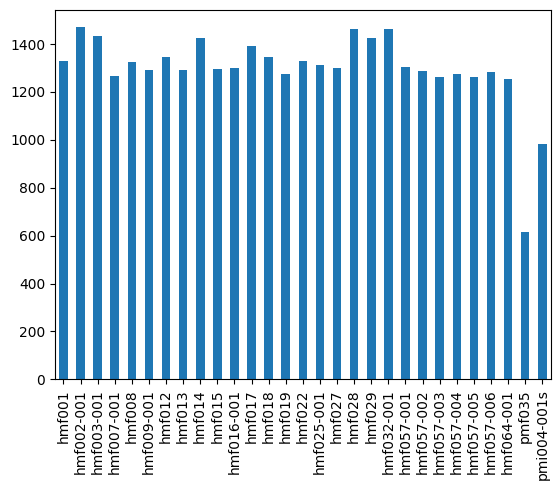

In [10]:
(bmarks.get_nd_std()*1e5).plot(kind="bar")

In [11]:
res = bmarks.gls(covariances)

GLS Procedure Summary:
Prior X: 1578.978
Posterior X: 4908.897
Titles of Benchmarks Included: hmf001, hmf002-001, hmf003-001, hmf007-001, hmf008, hmf009-001, hmf012, hmf013, hmf014, hmf015, hmf016-001, hmf017, hmf018, hmf019, hmf022, hmf025-001, hmf027, hmf028, hmf029, hmf032-001, hmf057-001, hmf057-002, hmf057-003, hmf057-004, hmf057-005, hmf057-006, hmf064-001, pmf035, pmi004-001s
Condition Number: 6875117.90


In [12]:
nd_std_post = pd.Series(np.sqrt(np.diag(res['V_post_K'])), index=res['V_post_K'].index)

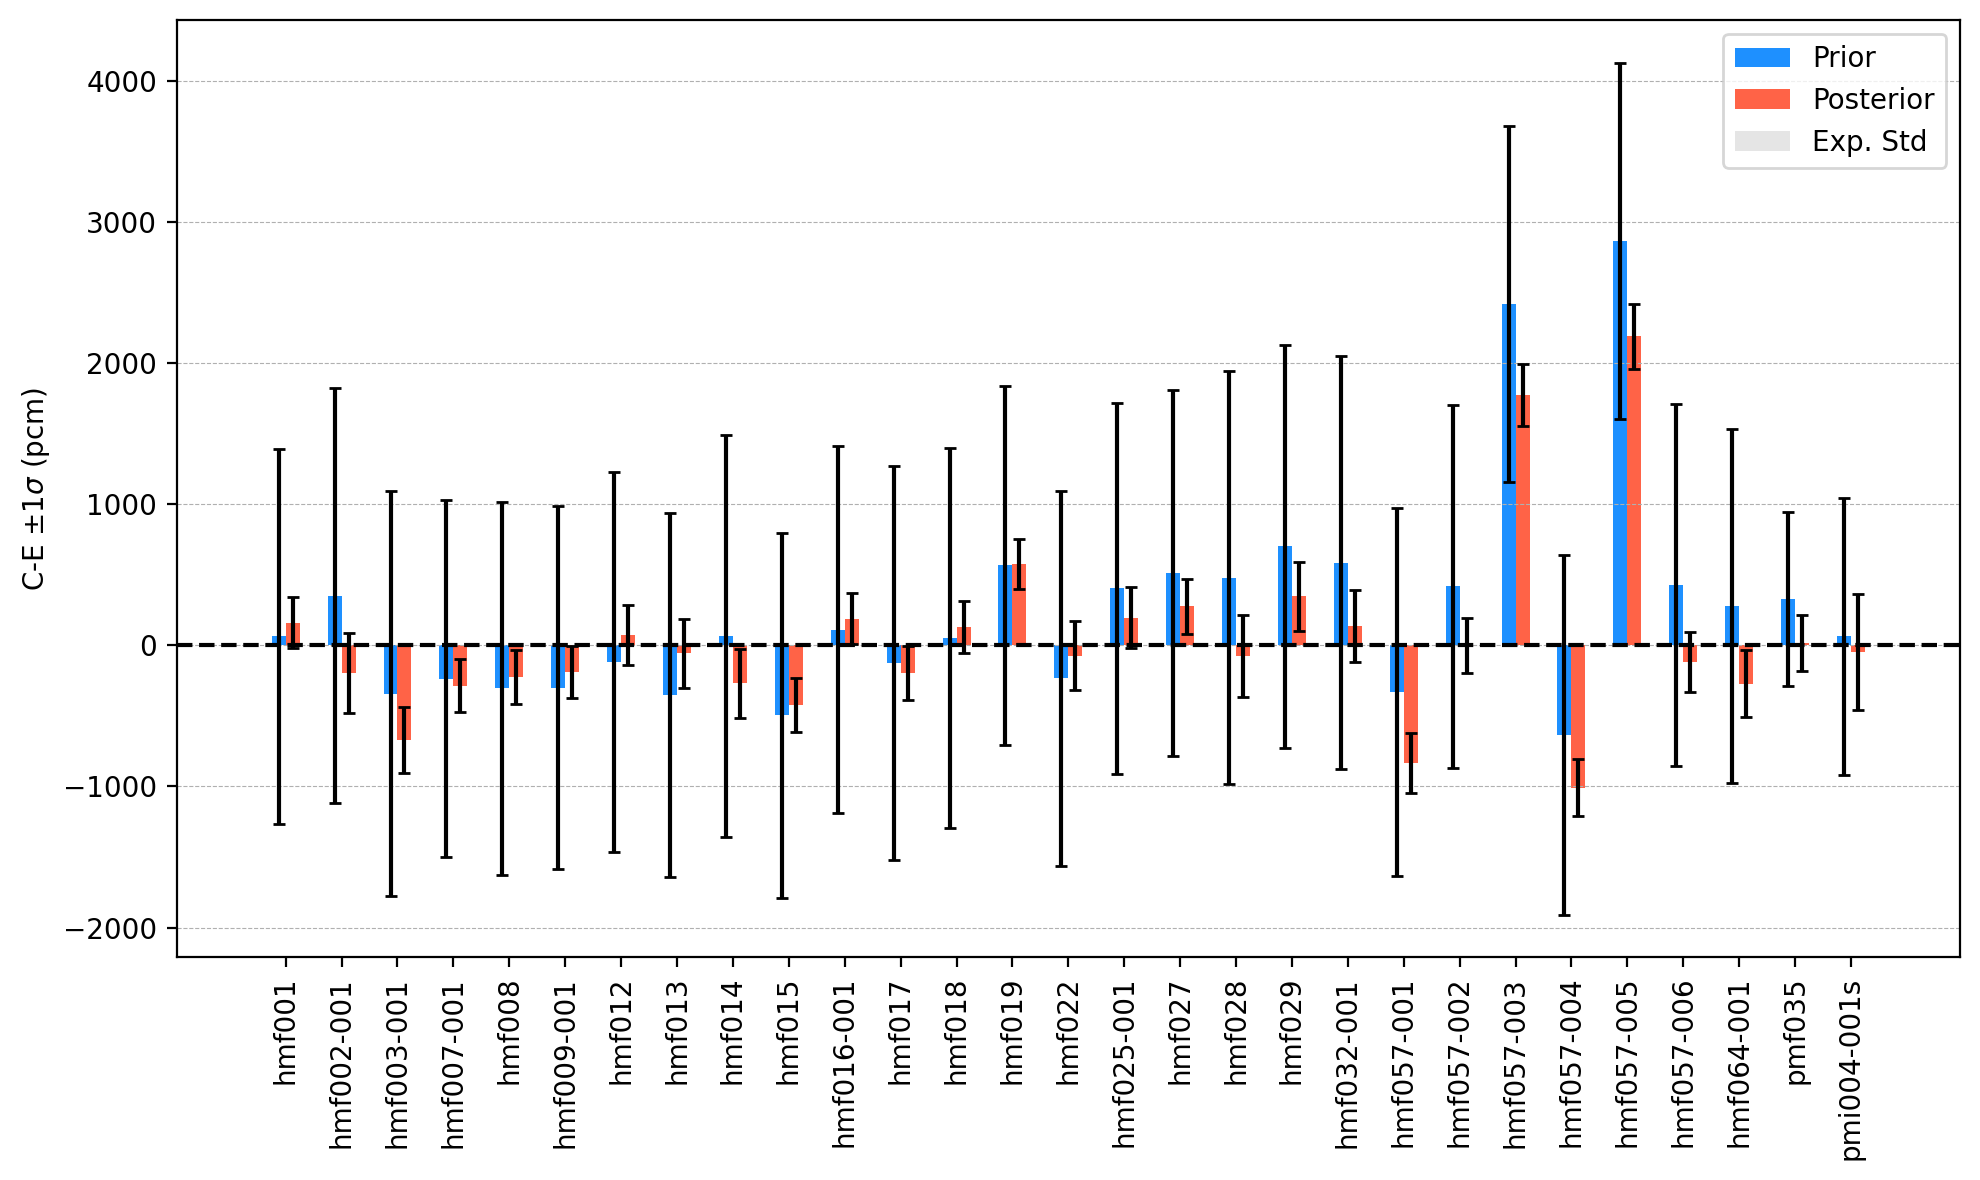

In [29]:
bar_width = 0.25

indices = np.arange(len(bmarks.K_prior.index))

fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
ax.bar(indices - bar_width/2, (bmarks.K_prior['K_prior'] - bmarks.K_exp['K_exp'])*1e5, width=bar_width, yerr=bmarks.get_nd_std()*1e5, 
       capsize=2, label='Prior', color='dodgerblue')
ax.bar(indices + bar_width/2, (res['K_post'].rename("K_post") - bmarks.K_exp['K_exp'])*1e5, width=bar_width, yerr=nd_std_post*1e5, 
       capsize=2, label='Posterior', color='tomato')
ax.bar(indices, np.diag(bmarks.V_exp)*2*1e5, width=bar_width*4, 
       bottom=-np.diag(bmarks.V_exp)*1e5, 
       color='black', alpha=0.1, label='Exp. Std')

ax.axhline(0, color='k', linestyle='--')

ax.set_xticks(indices)
ax.set_xticklabels(bmarks.K_prior.index, rotation=90)
ax.set_ylabel(r'C-E $\pm1\sigma$ (pcm)')
ax.legend()

plt.grid(axis='y', linestyle='--', linewidth=0.4)
plt.grid(axis='x', visible=False) 
plt.tight_layout()
#plt.savefig('GLLS_adjustment.png', dpi=300)
plt.show()

In [28]:
bmarks.C_inv

,hmf001,hmf002-001,hmf003-001,hmf007-001,hmf008,hmf009-001,hmf012,hmf013,hmf014,hmf015,...,hmf032-001,hmf057-001,hmf057-002,hmf057-003,hmf057-004,hmf057-005,hmf057-006,hmf064-001,pmf035,pmi004-001s
hmf001,2.86898e+08,-7.82229e+07,-8.19217e+07,3.11671e+07,-6.92785e+07,3.18348e+05,5.63452e+07,5.36973e+06,1.12199e+07,-1.47323e+08,...,-1.28040e+07,-4.26067e+07,-3.70046e+06,-1.33624e+08,-4.73012e+07,1.39236e+08,-1.56262e+07,4.20839e+07,-1.99752e+04,4.68993e+02
hmf002-001,-8.62953e+07,2.68612e+08,1.21065e+07,2.09827e+07,1.07264e+07,-1.47657e+07,4.33933e+07,-5.30940e+06,4.47975e+07,8.60128e+07,...,-5.87429e+06,2.22571e+06,1.48055e+07,9.06244e+06,3.96861e+07,-7.64011e+07,6.01166e+07,-1.58136e+07,2.84402e+02,2.17452e+04
hmf003-001,1.20432e+08,-5.68229e+07,-6.80331e+06,1.65084e+07,-1.69634e+07,3.22006e+07,-3.38726e+07,5.63977e+05,9.40025e+06,-6.62877e+07,...,3.71848e+07,1.56603e+07,6.91882e+07,-2.15131e+08,-1.54877e+08,2.20110e+08,-8.28063e+07,6.84733e+07,7.52661e+03,-4.41850e+04
hmf007-001,-8.98977e+07,5.67020e+07,1.54880e+08,4.38711e+07,7.60308e+06,-3.76813e+07,8.16865e+07,7.86348e+05,-5.63596e+07,-1.21387e+07,...,-2.08318e+07,-4.01135e+07,-1.24687e+08,1.02077e+08,8.65379e+07,-4.86383e+07,-5.47985e+06,3.24346e+07,-8.86618e+03,5.43416e+04
hmf008,-3.25469e+07,-3.77012e+06,3.27790e+07,-4.72744e+07,1.50910e+08,-1.67238e+07,-5.79885e+07,-3.48109e+06,4.72313e+07,2.33452e+07,...,2.03532e+07,1.82384e+07,1.97344e+07,1.17584e+07,-4.09523e+07,1.35932e+07,-1.98888e+07,-9.80802e+06,9.44332e+03,-2.17381e+04
hmf009-001,-4.40832e+07,6.70953e+05,2.43852e+07,-2.64334e+06,-7.22775e+06,6.58764e+07,-2.06377e+07,-3.97700e+05,-3.98982e+07,3.52241e+07,...,-6.99402e+06,3.69217e+06,-7.22808e+06,7.50007e+07,8.02853e+05,-3.40157e+07,-4.60182e+06,-2.32407e+07,6.76920e+03,1.33709e+04
hmf012,1.01220e+08,2.83982e+07,-4.11711e+07,5.53670e+07,-7.03446e+07,-1.73031e+07,1.52825e+08,5.25647e+05,1.81623e+07,-5.25844e+07,...,1.93657e+07,-3.44246e+07,4.20606e+05,-7.86034e+06,7.83920e+06,2.68755e+07,-6.50885e+06,1.47490e+07,-2.22151e+04,2.46625e+04
hmf013,1.69650e+06,-4.19940e+06,4.10457e+06,1.17986e+06,-1.93545e+06,-1.31647e+06,1.17835e+06,5.78383e+05,-6.05909e+06,-5.21555e+06,...,-1.92250e+06,-2.19848e+06,-4.56113e+06,1.72663e+06,2.78884e+06,-1.21442e+05,-9.81091e+05,1.81115e+06,1.86295e+03,-3.25528e+03
hmf014,-8.13428e+07,7.46360e+07,5.18107e+07,-1.84378e+07,7.76835e+07,-5.27791e+07,2.42289e+07,-5.20937e+06,1.10041e+08,5.15983e+07,...,7.15145e+06,-2.48190e+07,-5.52179e+07,8.80710e+07,6.54771e+07,-6.64502e+07,4.78859e+07,-2.72199e+07,-3.63175e+03,9.30126e+03
hmf015,2.09046e+07,3.49940e+07,-2.23862e+08,-3.29009e+07,-4.66116e+07,7.62972e+07,-8.14613e+07,-5.29868e+06,8.84192e+07,1.14788e+08,...,4.32747e+07,9.19826e+07,1.70251e+08,-1.00137e+08,-8.58758e+07,-3.22146e+06,4.51175e+07,-7.52125e+07,3.04990e+04,-7.55285e+04


In [15]:
bmarks.S.loc[922350].T @ res['delta_xs'][922350]

hmf001        -7.87402e-05
hmf002-001    -3.97104e-03
hmf003-001    -2.23117e-03
hmf007-001    -1.60428e-03
hmf008        -3.99734e-04
hmf009-001    -8.19321e-05
hmf012         3.30028e-04
hmf013        -1.63617e-03
hmf014        -2.53034e-03
hmf015        -8.14596e-04
hmf016-001    -4.48432e-04
hmf017        -1.82293e-03
hmf018        -2.12435e-04
hmf019        -8.48201e-04
hmf022        -3.01740e-06
hmf025-001    -5.48489e-04
hmf027        -9.78309e-04
hmf028        -4.08044e-03
hmf029        -2.64743e-03
hmf032-001    -3.04856e-03
hmf057-001    -4.92889e-04
hmf057-002    -9.40916e-04
hmf057-003    -1.64278e-03
hmf057-004    -5.18975e-04
hmf057-005    -1.65306e-03
hmf057-006    -1.07956e-03
hmf064-001    -9.06419e-04
pmf035         0.00000e+00
pmi004-001s    0.00000e+00
dtype: float64

In [16]:
import matplotlib.pyplot as plt
import sandy

In [17]:
def lethargywidths(self):
        """Calculate lethargy widths for each energy bin."""
        energies = pd.IntervalIndex.from_arrays(
            self.index.get_level_values('E_min_eV'),
            self.index.get_level_values('E_max_eV')
        )
        return np.log(energies.right / energies.left)

In [18]:
hmf001 = bmarks.get_benchmark('hmf001')
hmf013 = bmarks.get_benchmark('hmf013')

In [25]:
hmf001.S

hmf001  hmf001_std
ZAI    MT    E_min_eV    E_max_eV                           
70140  2     1.00000e-05 1.00000e-04 0.00000e+00 0.00000e+00
             1.00000e-04 5.00000e-04 0.00000e+00 0.00000e+00
             5.00000e-04 7.50000e-04 0.00000e+00 0.00000e+00
             7.50000e-04 1.00000e-03 0.00000e+00 0.00000e+00
             1.00000e-03 1.20000e-03 0.00000e+00 0.00000e+00
...                                          ...         ...
922380 35018 1.28400e+07 1.38400e+07 1.28601e-06 1.00000e+00
             1.38400e+07 1.45500e+07 7.70021e-07 1.00000e+00
             1.45500e+07 1.56830e+07 0.00000e+00 0.00000e+00
             1.56830e+07 1.73330e+07 0.00000e+00 0.00000e+00
             1.73330e+07 2.00000e+07 1.80412e-06 1.00000e+00

[7140 rows x 2 columns]

[(100.0, 20000000.0)]

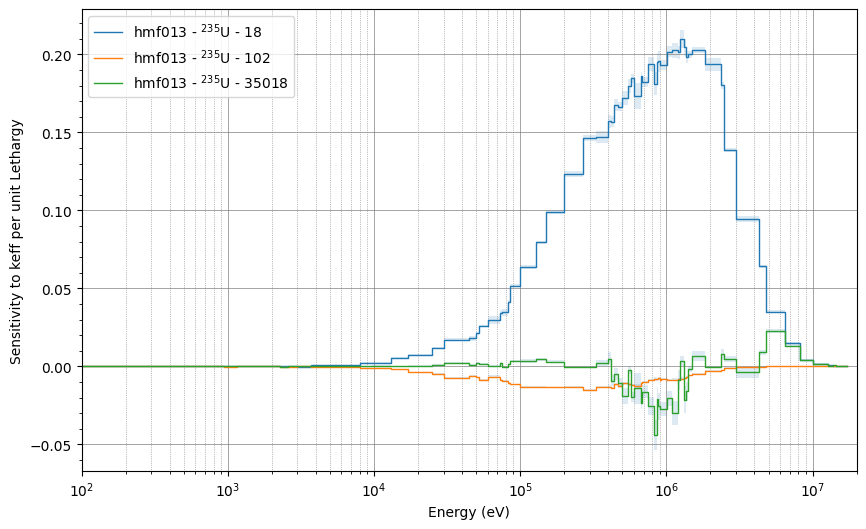

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
hmf013.plot_sensitivity([922350], [18, 102, 35018], ax=ax)
ax.set(xlim=(1e2, 2e7))

In [26]:
print(sandy.zam.zam2nuclide.__doc__)


    Convert ZAM to string such with symbol and mass, such as `922350` to
    `"U235"` or `952421` to `"Am242m"`.

    Parameters
    ----------
    zam : `int`
        nuclide ZAM indicator
    atomic_number : `bool`, optional, default is `False`
        flag to include the atomic number in the nuclide name
    sep : `str`, optional, default is `''`
        separation character(s) to place between the atomic number
        (if present), the element ID, and the mass number.

    Returns
    -------
    `string`
        nuclide expressed with symbol and mass

    Examples
    --------
    >>> zam2nuclide(922350)
    'U235'

    >>> zam2nuclide(922350, atomic_number=True)
    '92U235'

    >>> zam2nuclide(922350, atomic_number=True, sep="-")
    '92-U-235'

    >>> zam2nuclide(922350, atomic_number=False, sep="-")
    'U-235'

    >>> zam2nuclide(952420)
    'Am242'

    >>> zam2nuclide(952421)
    'Am242m'

    >>> zam2nuclide(952421, atomic_number=True, sep="_")
    '95_Am_242m'

    >

In [27]:
sandy.zam.zam2nuclide(922351, atomic_number=True, sep='-').lower() + "g.jeff4t4"

'92-u-235mg.jeff4t4'